# My First Inverse Kinematic (IK)

In this tutorial we will see how to use some [RBDyn](https://github.com/jorisv/RBDyn) algorithms and some Jacobians to compute the inverse kinematic.

We will not speak about analytic IK that is kind of obsolet. Instead we will focus on gradient based numerical optimization IK.

This tutorial will not be a course on gradient based numerical optimization.
Reader than want to see more on this topic can read [Methodt for non-linear least squares problems](http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3215/pdf) for an introduction.
The [Numerical Optimization](http://www.springer.com/fr/book/9780387303031) book is also a great ressource for this topic.

In [10]:
%gui wx
from IPython.display import Image
from tvtk.tools import ivtk
from graph import Axis

# create the viewer
viewer = ivtk.viewer()
viewer.size = (640, 480)

viewer.scene.camera.focal_point = (0.138, 0.958, -0.205)
viewer.scene.camera.position = (3.763, 1.435, 4.453)

display_number = 1
def display():
    global display_number
    path = 'img/MyFirstIK/%s.png' % display_number
    display_number += 1
    viewer.scene.save(path)
    return Image(path)

In [11]:
import numpy as np
import eigen as e
import sva
import rbdyn as rbd

from robots import TutorialTree

print 'TutorialTree structure:'
print TutorialTree.__doc__

# create a robot with the same structure than the one in the MultiBody tutorial
mbg, mb, mbc = TutorialTree()

TutorialTree structure:

  Return the MultiBodyGraph, MultiBody and the zeroed MultiBodyConfig with the
  following tree structure:

                b4
             j3 | Spherical
  Root     j0   |   j1     j2     j4
  ---- b0 ---- b1 ---- b2 ----b3 ----b5
  Fixed    RevX   RevY    RevZ   PrismZ
  


In [12]:
# draw the robot
from graph import MultiBodyViz

# add visualization of the of the b4 and b5 body that don't have any successors
X_b4_ef = sva.PTransformd(sva.RotY(-np.pi/2.), e.Vector3d(0.2, 0., 0.))
X_b5_ef = sva.PTransformd(sva.RotX(-np.pi/2.), e.Vector3d(0., 0.2, 0.))
mbv = MultiBodyViz(mbg, mb, endEffectorDict={'b4':(X_b4_ef, 0.1, (1., 1., 0.)),
                                             'b5':(X_b5_ef, 0.1, (1., 1., 0.))})

mbv.addActors(viewer.scene)

## One Task IK

We define a Task by the two following values:
 * $ \mathbf{g}(\mathbf{q}) $: An error
 * $ J_{\mathbf{g}} $: The $ \mathbf{g} $ error Jacobian $ \frac{\partial \mathbf{g}(\mathbf{q})}{\partial \mathbf{q}} $
 
Our objective is to solve the following problem:
$$
\underset{\mathbf{q}}{\text{minimize }} \frac{1}{2} \| \mathbf{g}(\mathbf{q}) \|^2
$$

This is a non-linear least squares problem so we can use a Gauss-Newton like method.

In this method we will compute a descent direction $ \mathbf{\alpha} $ by solving the following problem:
$$
(J_{\mathbf{g}}^T J_{\mathbf{g}}) \mathbf{\alpha} = -J_{\mathbf{g}}^T \mathbf{g}
$$
This problem can be solve by the following least square where $ ^{\#} $ is the pseudoinverse operator:
$$
\mathbf{\alpha} = -J_{\mathbf{g}}^{\#} \mathbf{g}
$$
Then we can integrate $ \mathbf{\alpha} $ to $ \mathbf{q} $ with the following equation $ \mathbf{q}_{k+1} = \mathbf{q}_{k} + \Delta_{st} \mathbf{\alpha}_{k} $ where $ \Delta_{st} $ is the integration step. In this tutorial we will not make any line search and set $ \Delta_{st} = 1 $.

Since the size of $ \mathbf{q} $ and $ \mathbf{\alpha} $ can be different because of some joint we will use the [eulerIntegration alogrithm](http://nbviewer.ipython.org/github/jorisv/sva_rbdyn_tutorials/blob/master/SomeAlgorithm.ipynb#Euler-Integration) to make this step.

In [19]:
def oneTaskMin(mb, mbc, task, delta=1., maxIter=100, prec=1e-8):
    q = rbd.paramToVector(mb, mbc.q)
    iterate = 0
    minimizer = False
    while iterate < maxIter and not minimizer:
        # compute task data
        g = task.g(mb, mbc)
        J = task.J(mb, mbc)
        
        # compute alpha
        alpha = -np.mat(np.linalg.lstsq(J, g)[0])
        
        # integrate and run the forward kinematic
        mbc.alpha = rbd.vectorToDof(mb, e.VectorXd(alpha))
        rbd.eulerIntegration(mb, mbc, delta)
        rbd.forwardKinematics(mb, mbc)
        
        # take the new q vector
        q = rbd.paramToVector(mb, mbc.q)
        
        alphaInf = np.linalg.norm(alpha, np.inf)
        yield iterate, q, alpha, alphaInf # yield the current state
        
        # check if the current alpha is a minimizer
        if alphaInf < prec:
            minimizer = True
        iterate += 1

### Body Task

Our first task will allow to target a static frame $ {}^{T} X_{O} $ for a frame $ p $ on a body $ b $ noted $ {}^{p} X_{O} = {}^{p} X_{b} {}^{b} X_{O} $.
The error function will be:
$$
\mathbf{g}^{body} = sva.transformError({}^{T} X_{O}, {}^{p} X_{O})
$$
The `sva::transformError` function will return the error in the Origin orientation frame so the the jacobian also have te be in this frame:
$$
J_{\mathbf{g}^{bdoy}} = \frac{\partial plx({}^{O} E_{p}) {}^{p} X_{O}(\mathbf{q})}{\partial \mathbf{q}}
$$

In [20]:
class BodyTask(object):
    def __init__(self, mb, bodyName, X_O_T, X_b_p=sva.PTransformd.Identity()):
        """
        Compute the error and the jacobian to target a static frame for a body.
        Parameters: 
            - mb: MultiBody
            - bodyName: ID of the body that should move
            - X_0_T: targeted frame (PTransformd)
            - X_b_p: static frame on the body bodyId
        """
        self.bodyIndex = mb.bodyIndexByName(bodyName)
        self.X_O_T = X_O_T
        self.X_b_p = X_b_p
        self.jac = rbd.Jacobian(mb, bodyName)
        self.jac_mat_sparse = e.MatrixXd(6, mb.nrDof())
            
    def X_O_p(self, mbc):
        X_O_b = list(mbc.bodyPosW)[self.bodyIndex]
        return self.X_b_p*X_O_b
        
    def g(self, mb, mbc):
        X_O_p = self.X_O_p(mbc)
        g_body = sva.transformError(self.X_O_T, X_O_p)
        return g_body.vector()
        
    def J(self, mb, mbc):
        X_O_p = self.X_O_p(mbc)
        # set transformation in Origin orientation frame
        X_O_p_O = sva.PTransformd(X_O_p.rotation()).inv()*X_O_p
        jac_mat_dense = self.jac.jacobian(mb, mbc, X_O_p_O)
        self.jac.fullJacobian(mb, jac_mat_dense, self.jac_mat_sparse)
        return self.jac_mat_sparse

### Configuration

We will target a frame $ {}^{T} X_O $ that the TutorialTree robot can reach with the body b5 end effector.

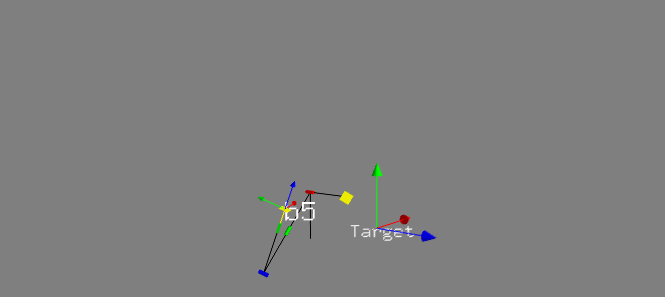

In [21]:
# Set an initial configuration
mbcIK = rbd.MultiBodyConfig(mbc)
quat = e.Quaterniond(np.pi/3., e.Vector3d(0.1, 0.5, 0.3).normalized())
mbcIK.q = [[],
           [3.*np.pi/4.],
           [np.pi/3.],
           [-3.*np.pi/4.],
           [0.],
           [quat.w(), quat.x(), quat.y(), quat.z()]]

rbd.forwardKinematics(mb, mbcIK)
rbd.forwardVelocity(mb, mbcIK) # for motionSubspace

# target frame
X_O_T = sva.PTransformd(sva.RotY(np.pi/2.), e.Vector3d(1.5, 0.5, 1.))

# create the task
bodyTask = BodyTask(mb, "b5", X_O_T, X_b5_ef)

# display initial configuration
from graph import Axis
axis_b5 = Axis(bodyTask.X_O_p(mbcIK), length=0.3, text='b5')
axis_T = Axis(X_O_T, length=0.5, text='Target')
axis_b5.addActors(viewer.scene)
axis_T.addActors(viewer.scene)

mbv.display(mb, mbcIK)
display()

### Result

The result is reached in 7 iterations !

 g_body translation error: [[2.220446049250313e-16], [1.1102230246251565e-16], [1.359631073446891e-32]]
g_body rotation error: [[-6.123233995736766e-17], [0.0], [-9.332627323203442e-18]]


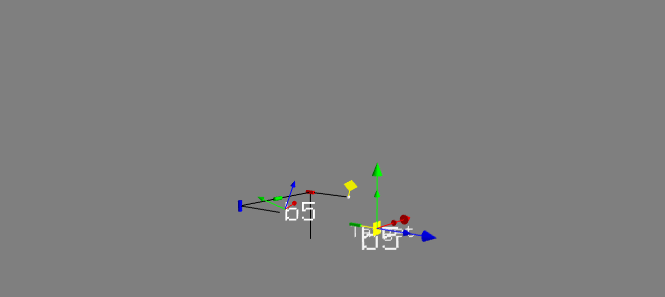

In [23]:
# copy the initial configuration to avoid the algorithm to change it
mbcIKSolve = rbd.MultiBodyConfig(mbcIK)
q_res = None
X_O_p_res = None
alphaInfList = []
for iterate, q, alpha, alphaInf in oneTaskMin(mb, mbcIKSolve, bodyTask, delta=1., maxIter=200, prec=1e-8):
    X_O_p = bodyTask.X_O_p(mbcIKSolve)
    q_res = q
    alphaInfList.append(alphaInf)
    
mbcIKResult = rbd.MultiBodyConfig(mbcIK)
mbcIKResult.q = rbd.vectorToParam(mb, q_res)
rbd.forwardKinematics(mb, mbcIKResult)

g_body = bodyTask.g(mb, mbcIKResult)
print 'g_body translation error:', g_body[3:]
print 'g_body rotation error:', g_body[:3]

axis_b5.X = X_O_p
mbv.display(mb, mbcIKResult)
display()

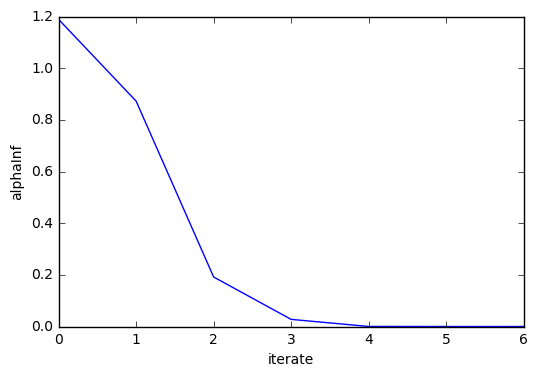

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(alphaInfList)
plt.ylabel('alphaInf')
plt.xlabel('iterate')

## Multi Task IK

This formulation has some flaw.
The BodyTask only give a target for the body b5, so the optimization process is free to move b4.

Another issue with the mono task IK is the Jacobian singularity. If at one point the BodyTask Jacobian become singular (rank deficient) the BodyTask minimization could fail. By providing more task to solve and redundancy we can solve this issue.

To solve this issue we can use a multi task IK (multi objective):
$$
\underset{\mathbf{q}}{\text{minimize }} \frac{1}{2} \sum\limits_{i=1}^{N} w_i\| \mathbf{g}_i(\mathbf{q}) \|^2
$$
Instead of minimizing one task error function we will minimize $ N $ task error function.

Some task can enter in conflict. By exemple a task that will move the MultiBody CoM can conflict with a BodyTask.

To solve this issue we give a weight $ w $ to each task. This weight will allow us to specify a *soft* priority to each task.

The mono task IK method will be used to solve the new problem but instead of using one task jacobian and error function we will stack each jacobian an error function together:
$$
J_{\mathbf{g}} = \begin{bmatrix} w_1 J_1 \\ \vdots \\ w_N J_N \end{bmatrix}
\mathbf{g} = \begin{bmatrix} w_1 \mathbf{g}_1 \\ \vdots \\ w_N \mathbf{g}_N \end{bmatrix}
$$

In [25]:
def manyTaskMin(mb, mbc, tasks, delta=1., maxIter=100, prec=1e-8):
    q = rbd.paramToVector(mb, mbc.q)
    iterate = 0
    minimizer = False
    while iterate < maxIter and not minimizer:
        # compute task data
        gList = map(lambda (w, t): w*t.g(mb, mbc), tasks)
        JList = map(lambda (w, t): w*t.J(mb, mbc), tasks)
        
        g = np.concatenate(gList)
        J = np.concatenate(JList)
        
        # compute alpha
        alpha = -np.mat(np.linalg.lstsq(J, g)[0])
        
        # integrate and run the forward kinematic
        mbc.alpha = rbd.vectorToDof(mb, e.VectorXd(alpha))
        rbd.eulerIntegration(mb, mbc, delta)
        rbd.forwardKinematics(mb, mbc)
        
        # take the new q vector
        q = rbd.paramToVector(mb, mbc.q)
        
        alphaInf = np.linalg.norm(alpha, np.inf)
        yield iterate, q, alpha, alphaInf # yield the current state
        
        # check if the current alpha is a minimizer
        if alphaInf < prec:
            minimizer = True
        iterate += 1

### Posture Task

The posture task will target one reference articular position vector $ \mathbf{q}_T $. This task is usually a low priority task that will ensure that body with no target will not move and also to always have a full rank jacobian during the optimisation process.

For simplicity we will only define the Posture Task for the revolute, prismatic or spherical joint.

The task error vector is:
$$
\mathbf{g}^{posture} = \begin{bmatrix} qError(\mathbf{q}_1, \mathbf{q}_{T_1}) \\ \vdots \\ qError(\mathbf{q}_N, \mathbf{q}_{T_N}) \end{bmatrix}
$$
Where $ qError \in \mathbb{R}^{A_i} $ will compute the articular target error depending of the joint.

The $ qError $ will have a different behavior depending of the joint type:
$$
 qError(\mathbf{q}_i, \mathbf{q}_{T_i}) =
 \begin{cases}
 \mathbf{q}_i - \mathbf{q}_{T_i} & \quad \text{if } joint_i \text{ is revolute/prismatic}\\
 sva.rotationError(\mathbf{q}_{T_i}, \mathbf{q}_i) & \quad \text{if } joint_i \text{ is spherical}
 \end{cases}
$$

The jacobian is:
$$
J_{\mathbf{g}^{posture}} =
\begin{bmatrix}
I^{A_1 \times A_1} & \cdots & \cdots \\
\vdots & \vdots & \vdots \\
\cdots & \cdots & I^{A_N \times A_N}
\end{bmatrix}
$$

In [29]:
class PostureTask(object):
    def __init__(self, mb, q_T):
        """
        Target a default configuration for the robot
        """
        self.q_T = q_T
        
        def isDefine(j):
            return j.type() in (rbd.Joint.Prism, rbd.Joint.Rev, rbd.Joint.Spherical)
        # take back joint and joint index that are define
        self.jointIndex = [i for i, j in enumerate(mb.joints()) if isDefine(j)]
        self.joints = [mb.joint(index) for index in self.jointIndex]
        nrDof = reduce(lambda dof, j: dof + j.dof(), self.joints, 0)
        
        # initialize g
        self.g_mat = np.mat(np.zeros((nrDof, 1)))
        
        # initialize the jacobian
        self.J_mat = np.mat(np.zeros((nrDof, mb.nrDof())))
        posInG = 0
        for jIndex, j in zip(self.jointIndex, self.joints):
            posInDof = mb.jointPosInDof(jIndex)
            self.J_mat[posInG:posInG+j.dof(),
                       posInDof:posInDof+j.dof()] = np.eye(j.dof())
            posInG += j.dof()
        
    def g(self, mb, mbc):
        q = map(list, mbc.q)
        jointConfig = list(mbc.jointConfig)
        posInG = 0
        for jIndex, j in zip(self.jointIndex, self.joints):
            if j.type() in (rbd.Joint.Prism, rbd.Joint.Rev):
                self.g_mat[posInG:posInG+j.dof(),0] = q[jIndex][0] - self.q_T[jIndex][0]
            elif j.type() in (rbd.Joint.Spherical,):
                orid = e.Quaterniond(*self.q_T[jIndex]).inverse().matrix()
                self.g_mat[posInG:posInG+j.dof(),0] =\
                    np.array(sva.rotationError(orid, jointConfig[jIndex].rotation()))
            posInG += j.dof()
        return self.g_mat
        
    def J(self, mb, mbc):
        return self.J_mat

### Configuration

Ok, let's try the same IK, but with the Posture Task as low-priority task.

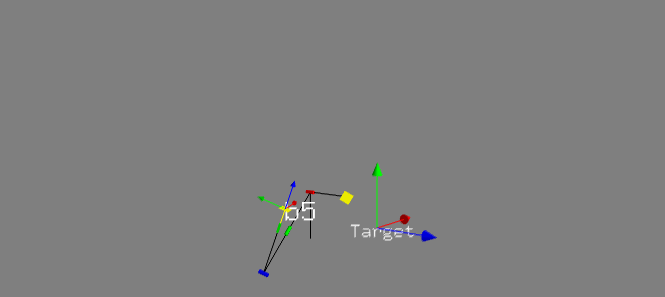

In [30]:
# Set an initial configuration
mbcMultiIK = rbd.MultiBodyConfig(mbcIK)

postureTask = PostureTask(mb, map(list, mbcMultiIK.q))

# display initial configuration
from graph import Axis
axis_b5.X = bodyTask.X_O_p(mbcMultiIK)
axis_T.X = X_O_T

mbv.display(mb, mbcMultiIK)
display()

### Result

Ok, nothing impressive in the result that is quite the same of the last one (see the q residual).

But we see that the Posture Task with a low priority is not interfering with the Body Task.

We will see in a next tutorial some application of the IK for a more complex robot like a humanoid.

g_body translation error: [[-7.999999995789153e-09], [1.847995756421028e-09], [-3.6249144796940418e-09]]
g_body rotation error: [[9.701977151073771e-09], [2.4166097638065733e-09], [7.699981882786949e-09]]
g_posture error: [[-0.78539815 -1.04719754  0.78539816  0.79999999  0.          0.          0.        ]]
residual between the two solution: 1.49418234365e-08


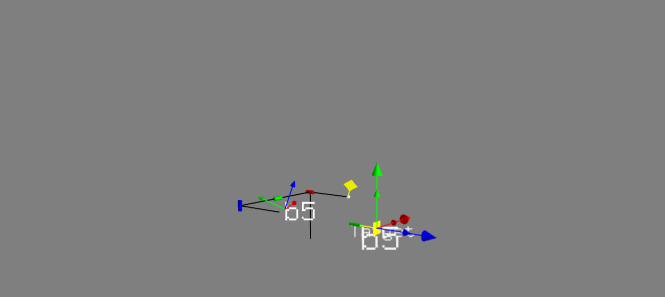

In [34]:
# copy the initial configuration to avoid the algorithm to change it
mbcMultiIKSolve = rbd.MultiBodyConfig(mbcMultiIK)
# set the weight of bodyTask to 10000 and the weight of the postureTask to 1
tasks = [(10000., bodyTask), (1., postureTask)]
q_res = None
X_O_p_res = None
alphaInfList = []
for iterate, q, alpha, alphaInf in manyTaskMin(mb, mbcMultiIKSolve, tasks, delta=1., maxIter=200, prec=1e-8):
    X_O_p = bodyTask.X_O_p(mbcMultiIKSolve)
    q_res = q
    alphaInfList.append(alphaInf)
    
mbcMultiIKResult = rbd.MultiBodyConfig(mbcMultiIK)
mbcMultiIKResult.q = rbd.vectorToParam(mb, e.VectorXd(q_res))
rbd.forwardKinematics(mb, mbcMultiIKResult)

g_body = bodyTask.g(mb, mbcMultiIKResult)
g_posture = postureTask.g(mb, mbcMultiIKResult)
print 'g_body translation error:', g_body[3:]
print 'g_body rotation error:', g_body[:3]
print 'g_posture error:', g_posture.T

monoQRes = np.array(rbd.paramToVector(mb, mbcIKResult.q))
multiQRes = np.array(rbd.paramToVector(mb, mbcMultiIKResult.q))
print 'residual between the two solution:', np.linalg.norm(monoQRes - multiQRes)

axis_b5.X = X_O_p
mbv.display(mb, mbcMultiIKResult)
display()

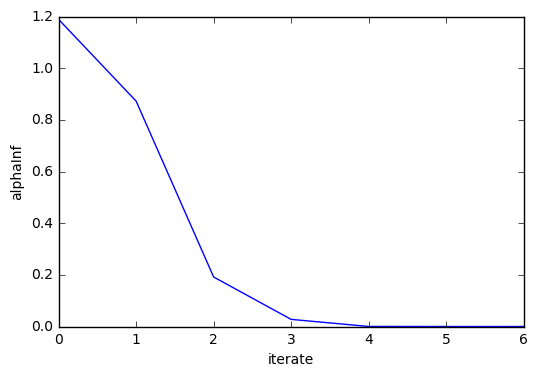

In [35]:
import matplotlib.pyplot as plt
plt.plot(alphaInfList)
plt.ylabel('alphaInf')
plt.xlabel('iterate')